In [ ]:
# fmt: off

### Necessary Imports

In [ ]:
import numpy as np
from matplotlib import ticker

from rtdip_sdk.pipelines.data_quality import KSigmaAnomalyDetection, IntervalFiltering, ArimaPrediction, MissingValueImputation, NormalizationMean, NormalizationZScore, NormalizationMinMax, Denormalization, DuplicateDetection, data_manipulation, IdentifyMissingDataPattern
from rtdip_sdk.pipelines.machine_learning import LinearRegression
from rtdip_sdk.pipelines.transformers.spark.machine_learning.columns_to_vector import ColumnsToVector
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import math
import random

spark_session = SparkSession.builder.master("local[2]").appName("test").getOrCreate()


### Introduction

I'm [name], a Data Engineer at Shell. [More Explanation to why to do that.]

### Source of Data

The source data is sourced from the data given from Shell.

In [ ]:
source_df = pd.read_pickle('./ExampleData.pkl')
tagname_to_select = '.0MI22YDSAXA3E0:S20'
source_df = source_df[source_df['TagName'] == tagname_to_select]

source_df['EventTime'] = pd.to_datetime(source_df['EventTime'], format='mixed')
source_df = source_df.sort_values(by='EventTime')

def create_value_plot(value_df = None, secondary_value_df = None, title = 'Unnamed Plot', x_label = 'Index', y_label = 'Primary Label', secondary_y_label = 'Secondary Value', share_y_axis = False, xlim = None, ylim = None, y_sec_lines = None, linestyle = '--'):
    value_df.index = pd.to_datetime(value_df['EventTime'], format='mixed')
    value_df = value_df['Value']
    if secondary_value_df is not None:
        secondary_value_df.index = pd.to_datetime(secondary_value_df['EventTime'], format='mixed')
        secondary_value_df = secondary_value_df['Value']

    fig, ax = plt.subplots()
    ax.plot(value_df, linestyle)
    ax.set_xlabel(x_label)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m.%Y \n %H:%M:%S"))
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_ylim([value_df.min(), value_df.max()] if ylim is None else ylim)
    ax.set_xlim([value_df.index.min(), value_df.index.max()] if xlim is None else xlim)
    ax.grid(axis='y')

    if secondary_value_df is not None:
        ax2 = ax.twinx()
        color='tab:red'
        ax2.set_ylabel(secondary_y_label, color=color)
        ax2.plot(secondary_value_df, linestyle, color=color, linewidth=3,)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_ylim(ax.get_ylim() if share_y_axis else [secondary_value_df.min(), secondary_value_df.max()])
        ax2.set_xlim(ax.get_xlim())
        if y_sec_lines is not None:
            for y_sec_line in y_sec_lines:
                ax2.axhline(y_sec_line, color= 'gray', linestyle = linestyle)


    fig.tight_layout()
    plt.show()
    plt.clf()

def add_extreme_spikes(value_df, entries_to_spike=25):
    random.seed(0)
    samples = value_df.sample(n=entries_to_spike, random_state=1)
    mask = value_df.index.isin(samples.index)
    value_df.loc[mask, 'Value'] = value_df.loc[mask, 'Value'].apply(lambda x: x + 5.0 if random.random() < 0.5 else x - 5.0)
    return value_df

def add_duplicate_data(value_df, entries_to_duplicate=25):
    random.seed(0)
    samples = value_df.head(n=entries_to_duplicate)
    value_df = pd.concat([value_df, samples])
    return value_df

create_value_plot(source_df, title='Sensor Data')

start_time = pd.to_datetime('2024-06-24 0:00:00', format='%Y-%m-%d %X')
end_time = pd.to_datetime('2024-06-25 0:00:00', format='%Y-%m-%d %X')
# Slicing by end dates is only possible if index is sorted by time
source_df = source_df[start_time:end_time]

# Add artificial data to spike
source_df = add_extreme_spikes(source_df)
ext_source_df = source_df
source_df = add_duplicate_data(source_df)
dup_source_df = source_df
source_df = source_df.sort_index()

create_value_plot(source_df, title='Sensor Data [Subset]')

df_0 = spark_session.createDataFrame(source_df, ['TagName', 'EventTime', 'Status', 'Value'])

### Normalization
*Scenario*:
We want to normalize sensor data, so it better used in other components or Machine Learning applications.
We show our three implemented methods of normalization: Z-score, min-max & mean.
The denormalization of data is also supported, e. g. for storing processed data in a human-readable format.

In [ ]:
# Prepare Pipeline Compoment
z_score_norm = NormalizationZScore(df=df_0, column_names=['Value'], in_place=True)
# Execute the normalization on the dataframe
df_1 = z_score_norm.filter()
# Denormalization of Z-Score DF
# denorm = Denormalization(df=z_score_df, normalization_to_revert=z_score_norm)
# z_score_df = z_score_df.toPandas().set_index(april_df.index)
# denorm_df = denorm.filter().toPandas().set_index(april_df.index)

In [ ]:
create_value_plot(value_df=df_0.toPandas(), secondary_value_df=df_1.toPandas(), title='Sensor Data [Subset]', y_label = 'Values',  secondary_y_label='Z-Score Normalized Value')

### Duplicate Detection
*Scenario*:
Because of some error reading in the sensor data, some entries are duplicated.
Cleaning these will decrease the size of the dataframe without losing any information.


In [ ]:
print('Before Duplicate Removal')
df_1.filter('EventTime = "2024-06-24 00:00:31.212"').show()
random.seed(0)
df_2 = DuplicateDetection(df=df_1, primary_key_columns=['EventTime']).filter()
print('After Duplicate Removal')
df_2.filter('EventTime = "2024-06-24 00:00:31.212"').show()


### Sigma Anomaly Detection
*Scenario*:
In raw sensor data, there are sometimes measurement outliers or errors, which pollute the data.
Identifying these spikes and removing them improves the data quality.

In [ ]:
random.seed(0)
# Execute Pipeline
df_3 = KSigmaAnomalyDetection(spark_session, df=df_2, column_names=['Value'], k_value=2.0, use_median=False).filter()

In [ ]:
# Transform Data back into pandas
create_value_plot(value_df=df_2.toPandas(), secondary_value_df=df_3.toPandas(), title='Sensor Data [Subset] - Anomalies removed', share_y_axis=True, y_label = 'Values', secondary_y_label='Cleaned up values', ylim=[-3.5, 3.5], y_sec_lines = [-2.0, 2.0])

### Value Imputation
*Scenario*:
Sometimes a value is missing because of sensor error or similar issues. This makes it difficult to use these time series on algorithms expecting a time series without gaps. To fix that issue, Value Imputation is used to fill in these gaps with meaningful values.



In [ ]:
random.seed(0)
# Execute Pipeline
start_time = pd.to_datetime('2024-06-24 3:00:00', format='%Y-%m-%d %X')
end_time = pd.to_datetime('2024-06-24 4:00:00', format='%Y-%m-%d %X')
# Slicing by end dates is only possible if index is sorted by time
# df_3_gap = df_3.filter(F.col('EventTime').between(start_time, end_time))
# df_4 = df_3.join(df_3_gap, on='EventTime', how='left_anti')
# df_4_gap = MissingValueImputation(spark_session, df=df_3_gap, tolerance_percentage=10).filter()
# df_4 = df_4.unionByName(df_4_gap).sort(['EventTime'])
df_4 = MissingValueImputation(spark_session, df=df_3, tolerance_percentage=1).filter()
# df_4.show()

In [ ]:
df_3_pd = df_3.toPandas().set_index('EventTime', drop=False)
df_4_pd = df_4.toPandas().set_index('EventTime', drop=False)
# Transform Data back into pandas
create_value_plot(value_df=df_4_pd[start_time:end_time], secondary_value_df=df_3_pd[start_time:end_time], title='Sensor Data [Subset] - Value Imputation', share_y_axis=True, y_label = 'Values', secondary_y_label='Imputated values', ylim=[-2.0, 2.0], linestyle='o')
print(df_4.toPandas().shape[0])

### ARIMA Prediction
*Scenario*:
We want to predict how much solar energy will be used next week. For that we will apply the reduced data from Interval Filtering on a ARIMA-Model.

In [ ]:
# Reuse Output Dataframe from Interval Filtering, since that reduces amount of points needed to a manageable amount
df_5_a = ArimaPrediction(past_data=df_4, to_extend_name=tagname_to_select, number_of_data_points_to_analyze=100, number_of_data_points_to_predict=100,
                             order=(3,0,1), seasonal_order=(2,1,1,50), trend='n').filter()

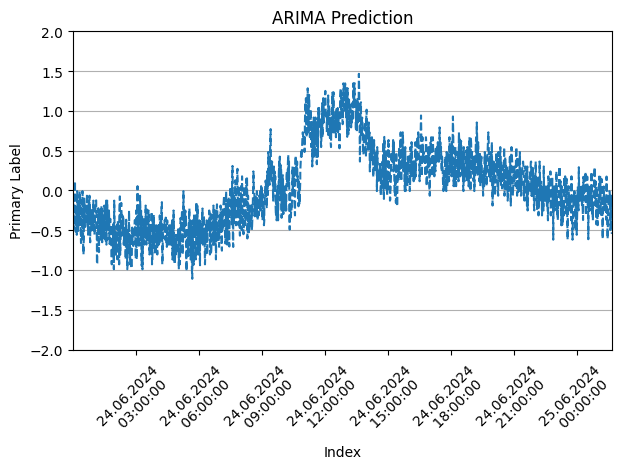

<Figure size 640x480 with 0 Axes>

In [94]:
df_5_a_pd = df_5_a.toPandas()
df_5_a_pd['Value'] = pd.to_numeric(df_5_a_pd['Value'])
plot_start_time = pd.to_datetime('2024-06-24 10:30:00', format='%Y-%m-%d %X')
plot_end_time = pd.to_datetime('2024-06-24 11:30:00', format='%Y-%m-%d %X')
create_value_plot(value_df=df_5_a_pd, share_y_axis=True,
                    ylim=(-2, 2), title='ARIMA Prediction')

### Linear Regression
*Scenario*:
We want to predict how much solar energy will be used next week. For that we will apply the reduced data from Interval Filtering on a ARIMA-Model.

In [ ]:
# Reuse Output Dataframe from Interval Filtering, since that reduces amount of points needed to a manageable amount
df_4_vec = ColumnsToVector(df=df_4, input_cols=["Value"], output_col="features").transform()

linear_regression = LinearRegression(
        df_4_vec,
        features_col="features",
        label_col="Value",
        prediction_col="prediction",
    )

train_df, test_df = linear_regression.split_data(train_ratio=0.8)

model = linear_regression.train(train_df)
df_5_b = model.predict(df_4_vec)

### Denormalization
*Scenario*:
We want to predict how much solar energy will be used next week. For that we will apply the reduced data from Interval Filtering on a ARIMA-Model.

In [ ]:
# Prepare Pipeline Compoment
z_score_denorm = Denormalization(df=df_5_a, normalization_to_revert=z_score_norm)
# Execute the normalization on the dataframe
df_6 = z_score_denorm.filter()

In [ ]:
create_value_plot(value_df=df_6.toPandas(), title='Sensor Data [Subset]', y_label = 'Z-Score Renormalized Value')